# Animal Face Classifier (CNN Multiclass Model)

## Importing Libraries

In [1]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

print(f'Usando PyTorch versão: {torch.__version__}')

Usando PyTorch versão: 2.6.0+cu124


## Class Architecture

In [2]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

## Loading Dataset and Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
from google.colab import files
print("Faça o upload do arquivo 'kaggle.json' que você baixou.")
files.upload()



Faça o upload do arquivo 'kaggle.json' que você baixou.


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brunocoimbra","key":"259a012f26c64c6162018cabf3bcb2b7"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# 1. Baixa o dataset do Kaggle (isso pode levar um minuto)
# O nome do dataset na API é 'andrewmvd/animal-faces'
!kaggle datasets download -d andrewmvd/animal-faces --force

# 2. Descompacta o arquivo zipado no diretório 'data'
# O -q faz com que a extração seja "silenciosa" (quiet)
!unzip -q animal-faces.zip -d ./data/

print("\nDataset baixado e descompactado com sucesso na pasta './data/'")

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 95% 664M/696M [00:07<00:00, 76.0MB/s]
100% 696M/696M [00:07<00:00, 98.3MB/s]

Dataset baixado e descompactado com sucesso na pasta './data/'


In [11]:
# O caminho agora é local, dentro do ambiente do Colab
train_dir = './data/afhq/train/'

# O resto do seu código permanece o mesmo
temp_transform = Compose([
    Resize((28, 28)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

try:
    temp_train_dataset = ImageFolder(
        root=train_dir,
        transform=temp_transform
    )
    print("Dataset de treino carregado com sucesso!")
    print(f"Número de imagens de treino: {len(temp_train_dataset)}")
    print(f"Classes encontradas: {temp_train_dataset.classes}")
except FileNotFoundError:
    print(f"ERRO: O diretório não foi encontrado em: {train_dir}")
    print("Certifique-se de que os passos de download e descompactação do Kaggle foram executados corretamente.")

Dataset de treino carregado com sucesso!
Número de imagens de treino: 14630
Classes encontradas: ['cat', 'dog', 'wild']


In [12]:
# 1. Cria um DataLoader para iterar sobre o dataset de treino temporário
# Usamos um batch_size maior aqui para acelerar o cálculo
temp_loader = DataLoader(temp_train_dataset, batch_size=64, num_workers=2)

# 2. Inicializa variáveis para os cálculos
n_pixels = len(temp_train_dataset) * 28 * 28
soma = torch.zeros(3)
soma_quadrados = torch.zeros(3)

# 3. Itera sobre o DataLoader para acumular as somas
print("Calculando média e desvio padrão do dataset de treino...")
for imagens, _ in temp_loader:
    # O tensor de imagens tem a forma (batch, canais, altura, largura)
    # Somamos ao longo do batch, altura e largura para cada canal
    soma += imagens.sum(axis=[0, 2, 3])
    soma_quadrados += (imagens ** 2).sum(axis=[0, 2, 3])

# 4. Calcula a média e o desvio padrão final
media = soma / n_pixels
desvio_padrao = torch.sqrt((soma_quadrados / n_pixels) - media ** 2)

print("Cálculo concluído!")
print(f"Média por canal (RGB): {media}")
print(f"Desvio padrão por canal (RGB): {desvio_padrao}")

Calculando média e desvio padrão do dataset de treino...
Cálculo concluído!
Média por canal (RGB): tensor([0.5022, 0.4599, 0.3994])
Desvio padrão por canal (RGB): tensor([0.2306, 0.2211, 0.2269])


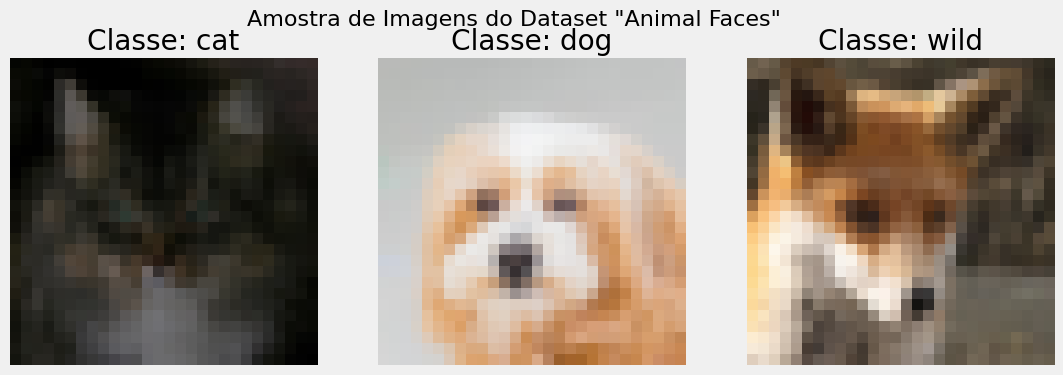

In [13]:
# Dicionário para mapear índices de classe para nomes
class_names = temp_train_dataset.classes
images_to_plot = {}

# Garante que temos um dataset para usar
if 'temp_train_dataset' in locals():
    # Itera sobre o dataset para encontrar uma imagem de cada classe
    for img, label in temp_train_dataset:
        if len(images_to_plot) == len(class_names):
            break # Sai do loop quando encontrar uma imagem de cada classe
        if label not in images_to_plot:
            images_to_plot[label] = img

    # Cria a figura para plotagem
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle('Amostra de Imagens do Dataset "Animal Faces"', fontsize=16)

    # Plota cada imagem encontrada
    # Usamos sorted() para garantir que a ordem seja sempre a mesma (cat, dog, wild)
    for i, label in enumerate(sorted(images_to_plot.keys())):
        ax = axs[i]
        # Matplotlib espera (H, W, C), mas o tensor do PyTorch é (C, H, W).
        # Usamos .permute() para reordenar as dimensões.
        ax.imshow(images_to_plot[label].permute(1, 2, 0))
        ax.set_title(f'Classe: {class_names[label]}')
        ax.axis('off') # Remove os eixos x e y

    plt.show()
else:
    print("Por favor, execute a célula anterior para carregar o 'temp_train_dataset' primeiro.")

In [14]:
# 1. Cria a transformação de normalização com os valores calculados
# ATENÇÃO: Substitua os valores de 'mean' e 'std' pelos que você obteve na célula anterior!
# Exemplo: normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalizer = Normalize(mean=media, std=desvio_padrao)

# 2. Define o pipeline de transformação final, incluindo a normalização
final_transform = Compose([
    Resize((28, 28)),
    ToImage(),
    ToDtype(torch.float32, scale=True),
    normalizer # Adiciona a normalização padronizada
])

# 3. Carrega os datasets de TREINO e VALIDAÇÃO
# O PyTorch usará as subpastas como classes automaticamente
train_dir = './data/afhq/train/'
val_dir = './data/afhq/val/' # O dataset do Kaggle já tem uma pasta de validação/teste

train_dataset = ImageFolder(root=train_dir, transform=final_transform)
val_dataset = ImageFolder(root=val_dir, transform=final_transform)

print(f"Dataset de treino final carregado com {len(train_dataset)} imagens.")
print(f"Dataset de validação carregado com {len(val_dataset)} imagens.")

# 4. Cria os DataLoaders finais
# Usamos shuffle=True para o treino, para que o modelo veja os dados em ordens diferentes a cada época
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# Não precisamos de shuffle para a validação
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

print("\nDataLoaders de treino e validação prontos!")

Dataset de treino final carregado com 14630 imagens.
Dataset de validação carregado com 1500 imagens.

DataLoaders de treino e validação prontos!


In [15]:
# Definindo a arquitetura do Modelo Base (CNN2)
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p

        # O "Featurizer" com dois blocos convolucionais
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)

        # O "Classifier" com camadas totalmente conectadas
        # A dimensão de entrada da primeira camada linear depende do tamanho da saída do featurizer.
        # Para uma entrada 28x28, a saída do featurizer é (n_feature x 5 x 5)
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3) # 3 classes de saída

        # Camada de Dropout
        self.drop = nn.Dropout(self.p)

    def forward(self, x):
        # Fluxo de dados no Featurizer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten antes de passar para o classificador
        x = nn.Flatten()(x)

        # Fluxo de dados no Classifier
        x = self.fc1(x)
        # Aplica dropout se a probabilidade for maior que zero
        if self.p > 0:
            x = self.drop(x)
        x = F.relu(x)

        # Para a camada final, geralmente não se aplica dropout
        x = self.fc2(x)

        return x

In [16]:
# 1. Configuração do Modelo Base
# Vamos começar com 64 filtros e sem dropout para ter um baseline.
# Estes são hiperparâmetros que você pode (e deve) ajustar depois.
torch.manual_seed(42)
modelo_base = CNN2(n_feature=64, p=0.0)

# 2. Configuração da Função de Perda
# Usamos CrossEntropyLoss para classificação multiclasse.
loss_fn = nn.CrossEntropyLoss()

# 3. Configuração do Otimizador
# Adam é uma escolha robusta e popular. A taxa de aprendizagem (lr) de 3e-4
# é um bom ponto de partida, como vimos na aula.
optimizer = optim.Adam(modelo_base.parameters(), lr=3e-4)

# Vamos imprimir o número de parâmetros treináveis do nosso modelo
print(f"O Modelo Base tem {sum(p.numel() for p in modelo_base.parameters() if p.requires_grad):,} parâmetros treináveis.")

O Modelo Base tem 118,923 parâmetros treináveis.


Iniciando o treinamento do Modelo Base...
Treinamento concluído!

Gerando gráfico de perdas...


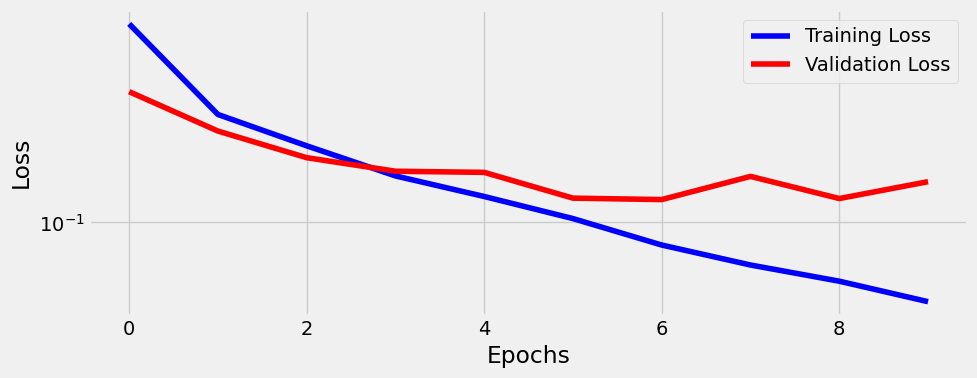

In [17]:
# 1. Junta todos os componentes na classe Architecture
arch_base = Architecture(modelo_base, loss_fn, optimizer)

# 2. Define os DataLoaders para treino e validação
arch_base.set_loaders(train_loader, val_loader)

# 3. Inicia o treinamento
# Vamos treinar por 10 épocas. Dependendo dos resultados, podemos ajustar depois.
print("Iniciando o treinamento do Modelo Base...")
arch_base.train(n_epochs=10)
print("Treinamento concluído!")

# 4. Plota as curvas de perda para análise
print("\nGerando gráfico de perdas...")
fig = arch_base.plot_losses()
plt.show()

Acurácia no conjunto de validação: 95.53%


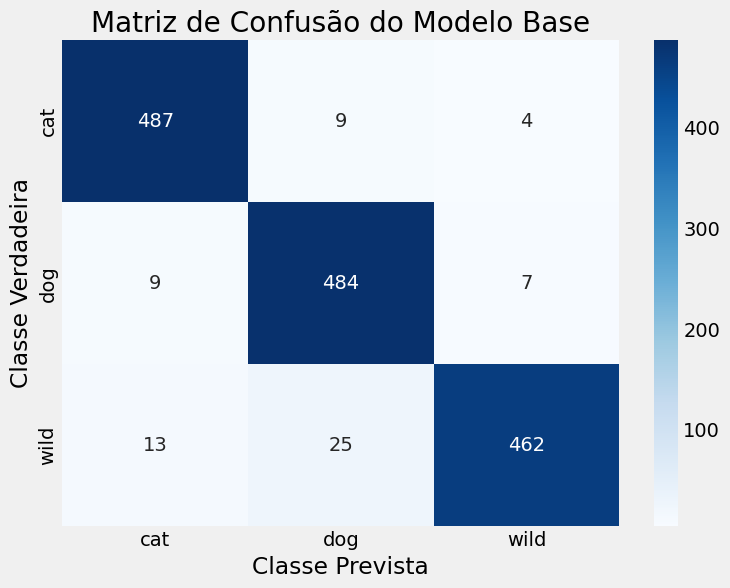

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Lista para armazenar as previsões e os rótulos verdadeiros
all_preds = []
all_labels = []

# Coloca o modelo em modo de avaliação
modelo_base.eval()
# Garante que não estamos calculando gradientes, para economizar memória e tempo
with torch.no_grad():
    # Itera sobre o val_loader
    for images, labels in val_loader:
        # Move os dados para o dispositivo (GPU)
        images = images.to(arch_base.device)
        labels = labels.to(arch_base.device)

        # Faz as previsões
        outputs = modelo_base(images)

        # Obtém a classe com maior probabilidade (argmax dos logits)
        _, predicted = torch.max(outputs, 1)

        # Adiciona as previsões e rótulos do lote às listas
        # .cpu() é necessário para mover os tensores da GPU de volta para a CPU
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcula a acurácia geral
accuracy = accuracy_score(all_labels, all_preds)
print(f"Acurácia no conjunto de validação: {accuracy * 100:.2f}%")

# Gera a matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plota a matriz de confusão de forma visual
plt.figure(figsize=(8, 6))
class_names = val_dataset.classes # Pega os nomes das classes (cat, dog, wild)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão do Modelo Base')
plt.show()

Acurácia no conjunto de validação: 95.53%

--- Relatório de Classificação (Precisão, Recall, F1-Score) ---
              precision    recall  f1-score   support

         cat       0.96      0.97      0.97       500
         dog       0.93      0.97      0.95       500
        wild       0.98      0.92      0.95       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500


--- Matriz de Confusão ---


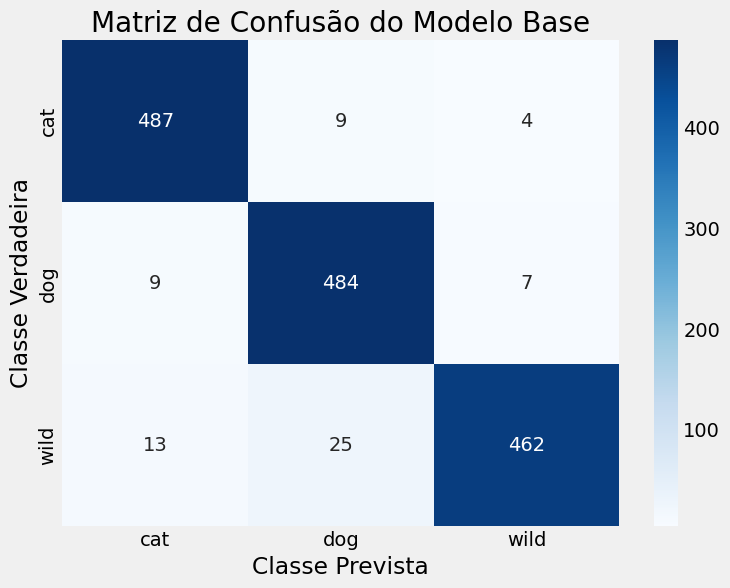

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Lista para armazenar as previsões e os rótulos verdadeiros
all_preds = []
all_labels = []

# Coloca o modelo em modo de avaliação
modelo_base.eval()
# Garante que não estamos calculando gradientes, para economizar memória e tempo
with torch.no_grad():
    # Itera sobre o val_loader
    for images, labels in val_loader:
        # Move os dados para o dispositivo (GPU)
        images = images.to(arch_base.device)
        labels = labels.to(arch_base.device)

        # Faz as previsões
        outputs = modelo_base(images)

        # Obtém a classe com maior probabilidade (argmax dos logits)
        _, predicted = torch.max(outputs, 1)

        # Adiciona as previsões e rótulos do lote às listas
        # .cpu() é necessário para mover os tensores da GPU de volta para a CPU
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Pega os nomes das classes (cat, dog, wild) para os relatórios
class_names = val_dataset.classes

# --- NOVAS ADIÇÕES COMEÇAM AQUI ---

# Calcula a acurácia geral (como antes)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Acurácia no conjunto de validação: {accuracy * 100:.2f}%\n")

# Gera e imprime o relatório de classificação completo
print("--- Relatório de Classificação (Precisão, Recall, F1-Score) ---")
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

# --- FIM DAS NOVAS ADIÇÕES ---

# Gera a matriz de confusão (como antes)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plota a matriz de confusão de forma visual
print("\n--- Matriz de Confusão ---")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão do Modelo Base')
plt.show()

## Experimento com Dropout

O Modelo com Dropout tem 118,923 parâmetros treináveis.

Iniciando o treinamento do Modelo com Dropout...
Treinamento concluído!

Gerando gráfico de perdas do modelo com Dropout...


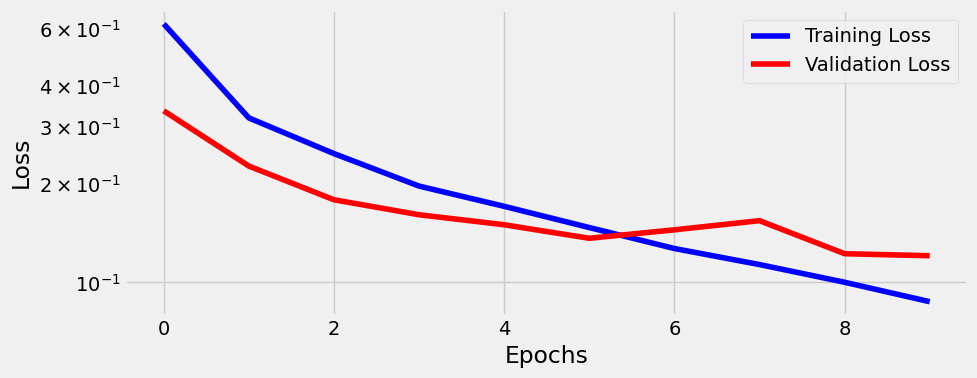

In [19]:
# --- Experimento com Dropout ---

# 1. Configuração do Modelo com Dropout
# Usamos os mesmos 64 filtros, mas agora com uma probabilidade de dropout de 50%
torch.manual_seed(42)
modelo_dropout = CNN2(n_feature=64, p=0.5)

# 2. Configuração da Função de Perda (a mesma de antes)
loss_fn_dropout = nn.CrossEntropyLoss()

# 3. Configuração do Otimizador para o novo modelo
optimizer_dropout = optim.Adam(modelo_dropout.parameters(), lr=3e-4)

# Imprime o número de parâmetros (deve ser o mesmo do modelo base)
print(f"O Modelo com Dropout tem {sum(p.numel() for p in modelo_dropout.parameters() if p.requires_grad):,} parâmetros treináveis.")

# 4. Junta tudo na classe Architecture
arch_dropout = Architecture(modelo_dropout, loss_fn_dropout, optimizer_dropout)

# 5. Define os DataLoaders (os mesmos de antes)
arch_dropout.set_loaders(train_loader, val_loader)

# 6. Inicia o treinamento
print("\nIniciando o treinamento do Modelo com Dropout...")
arch_dropout.train(n_epochs=10)
print("Treinamento concluído!")

# 7. Plota as curvas de perda para análise
print("\nGerando gráfico de perdas do modelo com Dropout...")
fig_dropout = arch_dropout.plot_losses()
plt.show()

Acurácia do modelo COM DROPOUT no conjunto de validação: 96.13%


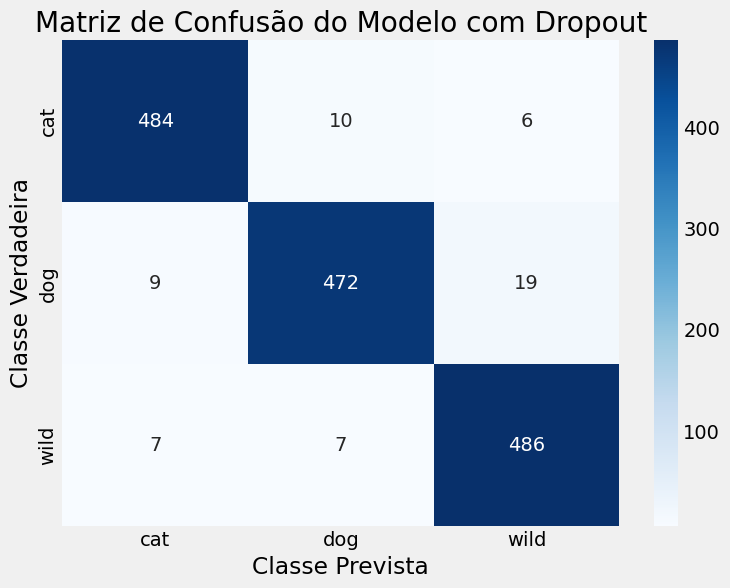

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Lista para armazenar as previsões e os rótulos verdadeiros
all_preds_dropout = []
all_labels_dropout = []

# Coloca o modelo com dropout em modo de avaliação
modelo_dropout.eval()
# Garante que não estamos calculando gradientes
with torch.no_grad():
    # Itera sobre o val_loader
    for images, labels in val_loader:
        # Move os dados para o dispositivo (GPU)
        images = images.to(arch_dropout.device)
        labels = labels.to(arch_dropout.device)

        # Faz as previsões com o modelo_dropout
        outputs = modelo_dropout(images)

        # Obtém a classe com maior probabilidade
        _, predicted = torch.max(outputs, 1)

        # Adiciona as previsões e rótulos do lote às listas
        all_preds_dropout.extend(predicted.cpu().numpy())
        all_labels_dropout.extend(labels.cpu().numpy())

# Calcula a acurácia geral do modelo com dropout
accuracy_dropout = accuracy_score(all_labels_dropout, all_preds_dropout)
print(f"Acurácia do modelo COM DROPOUT no conjunto de validação: {accuracy_dropout * 100:.2f}%")

# Gera a matriz de confusão
conf_matrix_dropout = confusion_matrix(all_labels_dropout, all_preds_dropout)

# Plota a matriz de confusão de forma visual
plt.figure(figsize=(8, 6))
class_names = val_dataset.classes
sns.heatmap(conf_matrix_dropout, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão do Modelo com Dropout')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Garante que as variáveis com as previsões e rótulos existem
if 'all_labels_dropout' in locals() and 'all_preds_dropout' in locals():
    # Pega os nomes das classes para o relatório
    class_names = val_dataset.classes

    # Gera e imprime o relatório de classificação
    # Ele inclui Precisão, Recall e F1-Score para cada classe
    report = classification_report(all_labels_dropout, all_preds_dropout, target_names=class_names)

    print("--- Relatório de Classificação do Modelo com Dropout ---")
    print(report)
else:
    print("Por favor, execute a célula anterior para calcular as previsões do modelo com dropout primeiro.")

--- Relatório de Classificação do Modelo com Dropout ---
              precision    recall  f1-score   support

         cat       0.97      0.97      0.97       500
         dog       0.97      0.94      0.95       500
        wild       0.95      0.97      0.96       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



## Model with n_features = 128 and dropout

In [23]:
# --- Experimento com n_feature = 128 e Dropout ---

# 1. Configuração do Modelo
torch.manual_seed(42)
# A única mudança é aqui: n_feature=128 e mantemos o dropout p=0.5
modelo_128f = CNN2(n_feature=128, p=0.5)

# 2. Configuração da Função de Perda (a mesma)
loss_fn_128f = nn.CrossEntropyLoss()

# 3. Configuração do Otimizador para o novo modelo
optimizer_128f = optim.Adam(modelo_128f.parameters(), lr=3e-4)

# Imprime o número de parâmetros (será bem maior agora!)
print(f"O Modelo com 128 filtros tem {sum(p.numel() for p in modelo_128f.parameters() if p.requires_grad):,} parâmetros treináveis.")

# 4. Junta tudo na classe Architecture
arch_128f = Architecture(modelo_128f, loss_fn_128f, optimizer_128f)

# 5. Define os DataLoaders (os mesmos de antes)
arch_128f.set_loaders(train_loader, val_loader)


O Modelo com 128 filtros tem 311,371 parâmetros treináveis.



Iniciando o treinamento do Modelo com 128 filtros...
Treinamento concluído!

Gerando gráfico de perdas do modelo com 128 filtros...


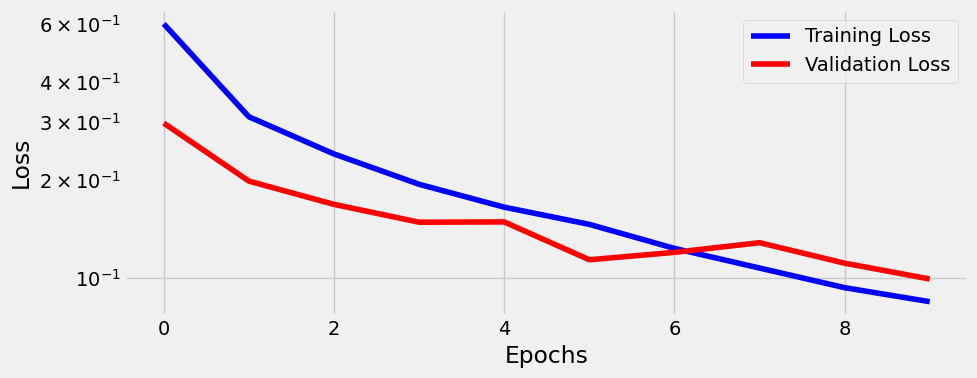

In [24]:
# 6. Inicia o treinamento
print("\nIniciando o treinamento do Modelo com 128 filtros...")
arch_128f.train(n_epochs=10)
print("Treinamento concluído!")

# 7. Plota as curvas de perda para análise
print("\nGerando gráfico de perdas do modelo com 128 filtros...")
fig_128f = arch_128f.plot_losses()
plt.show()

Acurácia do modelo com 128 filtros: 96.13%

--- Relatório de Classificação (Precisão, Recall, F1-Score) ---
              precision    recall  f1-score   support

         cat       0.96      0.98      0.97       500
         dog       0.97      0.94      0.96       500
        wild       0.96      0.96      0.96       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500


--- Matriz de Confusão ---


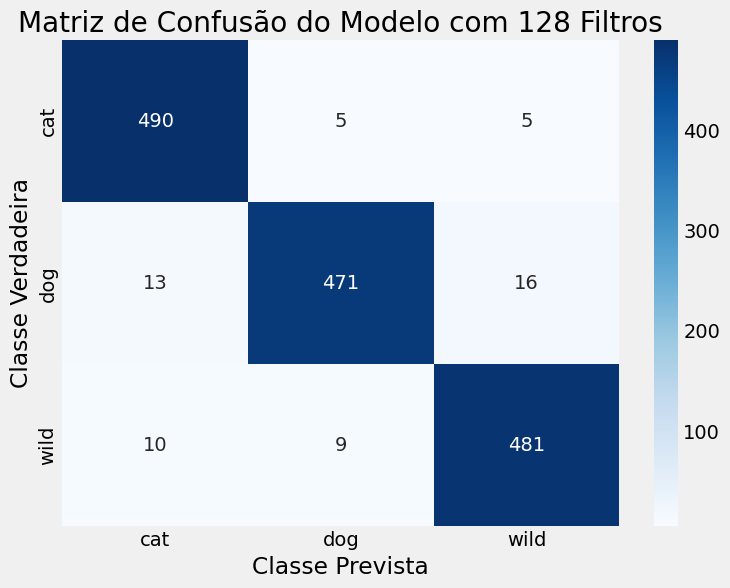

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Lista para armazenar as previsões e os rótulos do novo modelo
all_preds_128f = []
all_labels_128f = []

# Coloca o modelo de 128 filtros em modo de avaliação
modelo_128f.eval()
# Garante que não estamos calculando gradientes
with torch.no_grad():
    # Itera sobre o val_loader
    for images, labels in val_loader:
        # Move os dados para o dispositivo (GPU)
        images = images.to(arch_128f.device)
        labels = labels.to(arch_128f.device)

        # Faz as previsões com o modelo_128f
        outputs = modelo_128f(images)

        # Obtém a classe com maior probabilidade
        _, predicted = torch.max(outputs, 1)

        # Adiciona as previsões e rótulos do lote às listas
        all_preds_128f.extend(predicted.cpu().numpy())
        all_labels_128f.extend(labels.cpu().numpy())

# Pega os nomes das classes para os relatórios
class_names = val_dataset.classes

# --- Análise dos Resultados ---

# Calcula a acurácia geral
accuracy_128f = accuracy_score(all_labels_128f, all_preds_128f)
print(f"Acurácia do modelo com 128 filtros: {accuracy_128f * 100:.2f}%\n")

# Gera e imprime o relatório de classificação completo
print("--- Relatório de Classificação (Precisão, Recall, F1-Score) ---")
report_128f = classification_report(all_labels_128f, all_preds_128f, target_names=class_names)
print(report_128f)

# Gera a matriz de confusão
conf_matrix_128f = confusion_matrix(all_labels_128f, all_preds_128f)

# Plota a matriz de confusão de forma visual
print("\n--- Matriz de Confusão ---")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_128f, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão do Modelo com 128 Filtros')
plt.show()

## Modelo CNN3 (Tres blocos convolucionais).

In [26]:
# Definindo a nova arquitetura com 3 blocos convolucionais
class CNN3(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN3, self).__init__()
        self.n_feature = n_feature
        self.p = p

        # O "Featurizer" agora com três blocos
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3) # Novo Bloco

        # O "Classifier" com a dimensão de entrada ajustada
        # A saída do featurizer agora é (n_feature x 1 x 1)
        self.fc1 = nn.Linear(n_feature * 1 * 1, 50) # Tamanho ajustado!
        self.fc2 = nn.Linear(50, 3)

        # Camada de Dropout
        self.drop = nn.Dropout(self.p)

    def forward(self, x):
        # Bloco 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Bloco 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Bloco 3 (Novo)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten
        x = nn.Flatten()(x)

        # Classifier
        x = self.fc1(x)
        if self.p > 0:
            x = self.drop(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x

In [27]:
# --- Experimento com 3 Blocos Convolucionais ---

# 1. Instanciação do Modelo CNN3
torch.manual_seed(42)
# Mantemos n_feature=64 e o dropout p=0.5 para uma comparação justa
modelo_cnn3 = CNN3(n_feature=64, p=0.5)

# 2. Configuração da Função de Perda (a mesma)
loss_fn_cnn3 = nn.CrossEntropyLoss()

# 3. Configuração do Otimizador para o novo modelo
optimizer_cnn3 = optim.Adam(modelo_cnn3.parameters(), lr=3e-4)

# Imprime o número de parâmetros. Note como ele pode ser diferente do modelo CNN2.
print(f"O Modelo com 3 blocos (CNN3) tem {sum(p.numel() for p in modelo_cnn3.parameters() if p.requires_grad):,} parâmetros treináveis.")

# 4. Junta tudo na classe Architecture
arch_cnn3 = Architecture(modelo_cnn3, loss_fn_cnn3, optimizer_cnn3)

# 5. Define os DataLoaders (os mesmos)
arch_cnn3.set_loaders(train_loader, val_loader)


O Modelo com 3 blocos (CNN3) tem 79,051 parâmetros treináveis.



Iniciando o treinamento do Modelo com 3 blocos (CNN3)...
Treinamento concluído!

Gerando gráfico de perdas do modelo com 3 blocos...


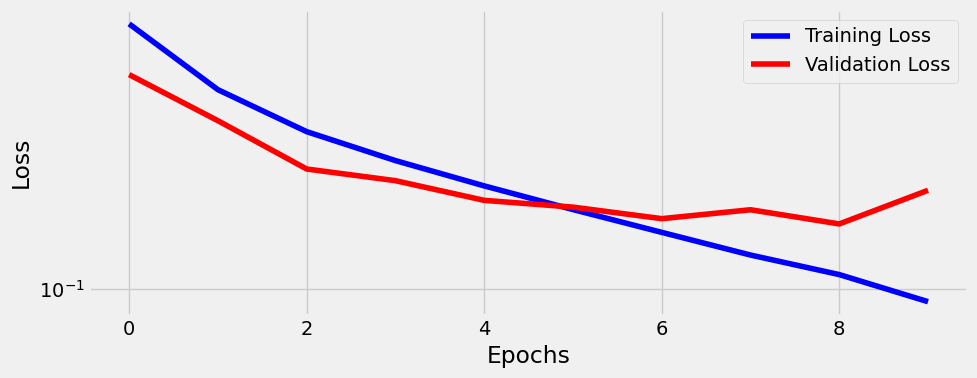

In [28]:
# 6. Inicia o treinamento
print("\nIniciando o treinamento do Modelo com 3 blocos (CNN3)...")
arch_cnn3.train(n_epochs=10)
print("Treinamento concluído!")

# 7. Plota as curvas de perda para análise
print("\nGerando gráfico de perdas do modelo com 3 blocos...")
fig_cnn3 = arch_cnn3.plot_losses()
plt.show()

Acurácia do modelo CNN3 (3 blocos): 93.00%

--- Relatório de Classificação (Precisão, Recall, F1-Score) ---
              precision    recall  f1-score   support

         cat       0.98      0.88      0.93       500
         dog       0.86      0.98      0.92       500
        wild       0.96      0.93      0.94       500

    accuracy                           0.93      1500
   macro avg       0.94      0.93      0.93      1500
weighted avg       0.94      0.93      0.93      1500


--- Matriz de Confusão ---


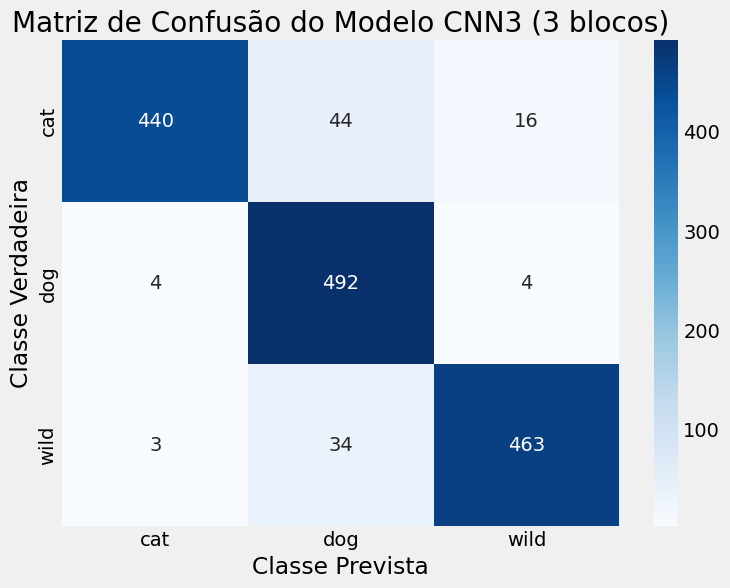

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Lista para armazenar as previsões e os rótulos do modelo CNN3
all_preds_cnn3 = []
all_labels_cnn3 = []

# Coloca o modelo CNN3 em modo de avaliação
modelo_cnn3.eval()
# Garante que não estamos calculando gradientes
with torch.no_grad():
    # Itera sobre o val_loader
    for images, labels in val_loader:
        # Move os dados para o dispositivo (GPU)
        images = images.to(arch_cnn3.device)
        labels = labels.to(arch_cnn3.device)

        # Faz as previsões com o modelo_cnn3
        outputs = modelo_cnn3(images)

        # Obtém a classe com maior probabilidade
        _, predicted = torch.max(outputs, 1)

        # Adiciona as previsões e rótulos do lote às listas
        all_preds_cnn3.extend(predicted.cpu().numpy())
        all_labels_cnn3.extend(labels.cpu().numpy())

# Pega os nomes das classes para os relatórios
class_names = val_dataset.classes

# --- Análise dos Resultados ---

# Calcula a acurácia geral
accuracy_cnn3 = accuracy_score(all_labels_cnn3, all_preds_cnn3)
print(f"Acurácia do modelo CNN3 (3 blocos): {accuracy_cnn3 * 100:.2f}%\n")

# Gera e imprime o relatório de classificação completo
print("--- Relatório de Classificação (Precisão, Recall, F1-Score) ---")
report_cnn3 = classification_report(all_labels_cnn3, all_preds_cnn3, target_names=class_names)
print(report_cnn3)

# Gera a matriz de confusão
conf_matrix_cnn3 = confusion_matrix(all_labels_cnn3, all_preds_cnn3)

# Plota a matriz de confusão de forma visual
print("\n--- Matriz de Confusão ---")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn3, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão do Modelo CNN3 (3 blocos)')
plt.show()

## CNN3 com Early Stop (8 Epochs)

Iniciando o treinamento do Modelo CNN3 com Early Stopping (8 épocas)...
Treinamento concluído!

--- Calculando Métricas para o Modelo de 8 Épocas ---
              precision    recall  f1-score   support

         cat       0.98      0.91      0.95       500
         dog       0.92      0.95      0.93       500
        wild       0.92      0.95      0.94       500

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



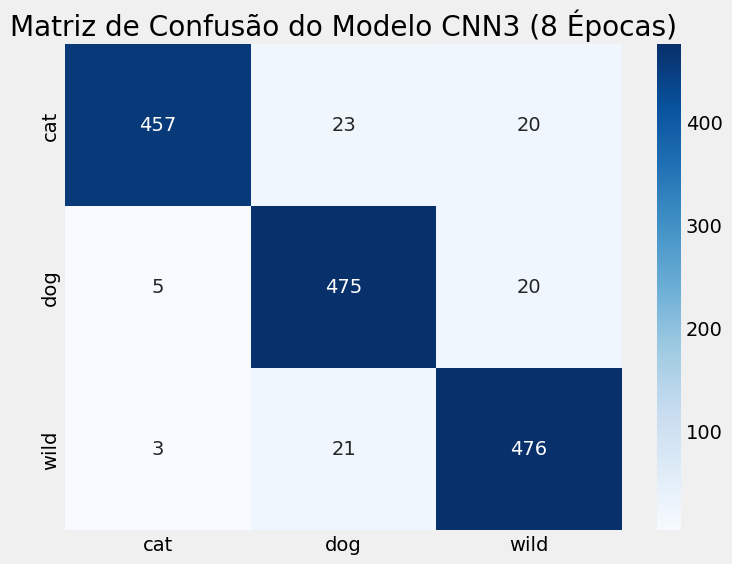

In [30]:
# --- Experimento com Early Stopping na Época 8 ---

# 1. Instanciação do Modelo CNN3 (como antes)
torch.manual_seed(42)
modelo_cnn3_8_epocas = CNN3(n_feature=64, p=0.5)

# 2. Configuração da Função de Perda e Otimizador
loss_fn_cnn3_8e = nn.CrossEntropyLoss()
optimizer_cnn3_8e = optim.Adam(modelo_cnn3_8_epocas.parameters(), lr=3e-4)

# 3. Junta tudo na classe Architecture
arch_cnn3_8e = Architecture(modelo_cnn3_8_epocas, loss_fn_cnn3_8e, optimizer_cnn3_8e)

# 4. Define os DataLoaders
arch_cnn3_8e.set_loaders(train_loader, val_loader)

# 5. Inicia o treinamento por APENAS 8 ÉPOCAS
print("Iniciando o treinamento do Modelo CNN3 com Early Stopping (8 épocas)...")
arch_cnn3_8e.train(n_epochs=8)
print("Treinamento concluído!")

# 6. Avalia o modelo imediatamente após o treino
print("\n--- Calculando Métricas para o Modelo de 8 Épocas ---")
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

all_preds_cnn3_8e = []
all_labels_cnn3_8e = []

modelo_cnn3_8_epocas.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(arch_cnn3_8e.device)
        labels = labels.to(arch_cnn3_8e.device)
        outputs = modelo_cnn3_8_epocas(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_cnn3_8e.extend(predicted.cpu().numpy())
        all_labels_cnn3_8e.extend(labels.cpu().numpy())

class_names = val_dataset.classes
report = classification_report(all_labels_cnn3_8e, all_preds_cnn3_8e, target_names=class_names)
print(report)

conf_matrix = confusion_matrix(all_labels_cnn3_8e, all_preds_cnn3_8e)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão do Modelo CNN3 (8 Épocas)')
plt.show()

## Meu Modelo (CNN2 + Image 64x64)

In [31]:
# --- Novo Pipeline de Dados para 64x64 ---

# 1. Transformação temporária para imagens 64x64
transform_64 = Compose([
    Resize((64, 64)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

# 2. Carrega o dataset de treino com a nova resolução
train_dataset_64 = ImageFolder(root='./data/afhq/train/', transform=transform_64)

# 3. Cria um DataLoader temporário para calcular as novas estatísticas
temp_loader_64 = DataLoader(train_dataset_64, batch_size=64, num_workers=2)

# 4. Calcula a nova média e desvio padrão
n_pixels_64 = len(train_dataset_64) * 64 * 64
soma_64 = torch.zeros(3)
soma_quadrados_64 = torch.zeros(3)

print("Calculando novas estatísticas para imagens 64x64...")
for imagens, _ in temp_loader_64:
    soma_64 += imagens.sum(axis=[0, 2, 3])
    soma_quadrados_64 += (imagens ** 2).sum(axis=[0, 2, 3])

media_64 = soma_64 / n_pixels_64
desvio_padrao_64 = torch.sqrt((soma_quadrados_64 / n_pixels_64) - media_64 ** 2)
print("Cálculo concluído!")
print(f"Nova Média: {media_64}")
print(f"Novo Desvio Padrão: {desvio_padrao_64}")


# 5. Cria o pipeline de transformação final e os DataLoaders definitivos
normalizer_64 = Normalize(mean=media_64, std=desvio_padrao_64)
final_transform_64 = Compose([
    Resize((64, 64)),
    ToImage(),
    ToDtype(torch.float32, scale=True),
    normalizer_64
])

train_dataset_final = ImageFolder(root='./data/afhq/train/', transform=final_transform_64)
val_dataset_final = ImageFolder(root='./data/afhq/val/', transform=final_transform_64)

train_loader_64 = DataLoader(train_dataset_final, batch_size=32, shuffle=True, num_workers=2)
val_loader_64 = DataLoader(val_dataset_final, batch_size=32, num_workers=2)

print("\nDataLoaders para imagens 64x64 prontos!")

Calculando novas estatísticas para imagens 64x64...
Cálculo concluído!
Nova Média: tensor([0.5022, 0.4599, 0.3994])
Novo Desvio Padrão: tensor([0.2420, 0.2323, 0.2376])

DataLoaders para imagens 64x64 prontos!


In [32]:
# --- "Seu Modelo": CNN2 para imagens 64x64 ---

class CNN2_64(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2_64, self).__init__()
        self.n_feature = n_feature
        self.p = p

        # Featurizer permanece o mesmo
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)

        # Classifier com a camada fc1 AJUSTADA para a nova dimensão
        # Após 2x pooling, 64x64 -> 31x31 -> 14x14.
        # Entrada do FC1 = n_feature * 14 * 14
        self.fc1 = nn.Linear(n_feature * 14 * 14, 50) # AJUSTE CRÍTICO AQUI
        self.fc2 = nn.Linear(50, 3)

        self.drop = nn.Dropout(self.p)

    def forward(self, x):
        # O fluxo de dados é idêntico ao da CNN2
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        if self.p > 0:
            x = self.drop(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [33]:
# --- Treinamento do Modelo Final (CNN2_64) ---

torch.manual_seed(42)
# Usamos a arquitetura vencedora: 64 features e dropout de 0.5
meu_modelo = CNN2_64(n_feature=64, p=0.5)

loss_fn_final = nn.CrossEntropyLoss()
optimizer_final = optim.Adam(meu_modelo.parameters(), lr=3e-4)

print(f"'Meu Modelo' (CNN2_64) tem {sum(p.numel() for p in meu_modelo.parameters() if p.requires_grad):,} parâmetros treináveis.")

arch_final = Architecture(meu_modelo, loss_fn_final, optimizer_final)
# Usamos os novos DataLoaders de 64x64
arch_final.set_loaders(train_loader_64, val_loader_64)


'Meu Modelo' (CNN2_64) tem 666,123 parâmetros treináveis.



Iniciando o treinamento do 'Meu Modelo'...
Treinamento concluído!


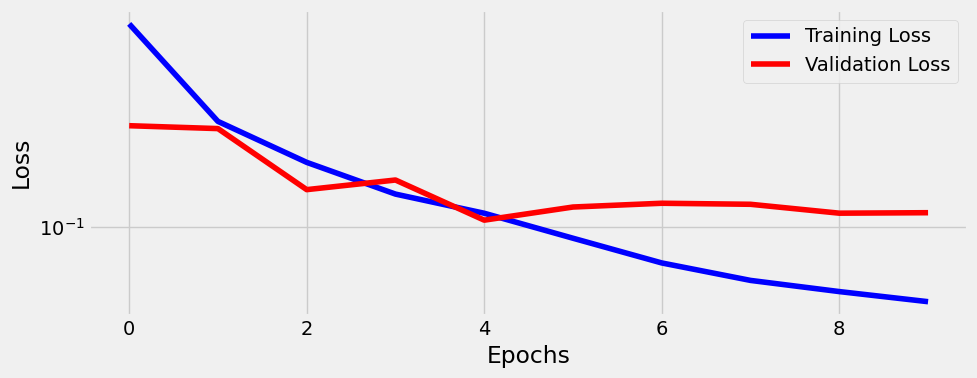

In [34]:
print("\nIniciando o treinamento do 'Meu Modelo'...")
arch_final.train(n_epochs=10)
print("Treinamento concluído!")

# Plota as curvas de perda
fig_final = arch_final.plot_losses()
plt.show()

Acurácia do 'Meu Modelo' (64x64): 96.87%

--- Relatório de Classificação (Precisão, Recall, F1-Score) ---
              precision    recall  f1-score   support

         cat       0.98      0.97      0.97       500
         dog       0.97      0.96      0.97       500
        wild       0.96      0.97      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500


--- Matriz de Confusão ---


<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

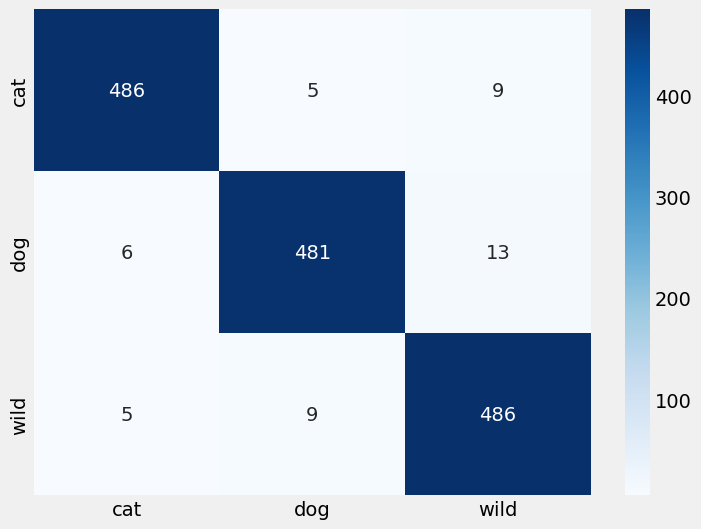

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Lista para armazenar as previsões e os rótulos do seu modelo final
all_preds_final = []
all_labels_final = []

# Coloca "Meu Modelo" em modo de avaliação
meu_modelo.eval()
# Garante que não estamos calculando gradientes
with torch.no_grad():
    # Itera sobre o val_loader de 64x64
    for images, labels in val_loader_64:
        # Move os dados para o dispositivo (GPU)
        images = images.to(arch_final.device)
        labels = labels.to(arch_final.device)

        # Faz as previsões com o seu modelo
        outputs = meu_modelo(images)

        # Obtém a classe com maior probabilidade
        _, predicted = torch.max(outputs, 1)

        # Adiciona as previsões e rótulos do lote às listas
        all_preds_final.extend(predicted.cpu().numpy())
        all_labels_final.extend(labels.cpu().numpy())

# Pega os nomes das classes para os relatórios
class_names = val_dataset_final.classes

# --- Análise dos Resultados Finais ---

# Calcula a acurácia geral
accuracy_final = accuracy_score(all_labels_final, all_preds_final)
print(f"Acurácia do 'Meu Modelo' (64x64): {accuracy_final * 100:.2f}%\n")

# Gera e imprime o relatório de classificação completo
print("--- Relatório de Classificação (Precisão, Recall, F1-Score) ---")
report_final = classification_report(all_labels_final, all_preds_final, target_names=class_names)
print(report_final)

# Gera a matriz de confusão
conf_matrix_final = confusion_matrix(all_labels_final, all_preds_final)

# Plota a matriz de confusão de forma visual
print("\n--- Matriz de Confusão ---")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_final, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# Lista para armazenar as previsões e os rótulos do seu modelo final
all_preds_final = []
all_labels_final = []

# Coloca "Meu Modelo" em modo de avaliação
meu_modelo.eval()
# Garante que não estamos calculando gradientes
with torch.no_grad():
    # Itera sobre o val_loader de 64x64
    for images, labels in val_loader_64:
        # Move os dados para o dispositivo (GPU)
        images = images.to(arch_final.device)
        labels = labels.to(arch_final.device)

        # Faz as previsões com o seu modelo
        outputs = meu_modelo(images)

        # Obtém a classe com maior probabilidade
        _, predicted = torch.max(outputs, 1)

        # Adiciona as previsões e rótulos do lote às listas
        all_preds_final.extend(predicted.cpu().numpy())
        all_labels_final.extend(labels.cpu().numpy())

# Pega os nomes das classes para os relatórios
class_names = val_dataset_final.classes

# --- Análise dos Resultados em Formato de Texto ---

# 1. Calcula e imprime a acurácia geral
accuracy_final = accuracy_score(all_labels_final, all_preds_final)
print(f"Acurácia do 'Meu Modelo' (64x64): {accuracy_final * 100:.2f}%\n")

# 2. Gera e imprime o relatório de classificação completo
print("--- Relatório de Classificação (Precisão, Recall, F1-Score) ---")
report_final = classification_report(all_labels_final, all_preds_final, target_names=class_names)
print(report_final)

# 3. Gera e imprime a matriz de confusão como uma matriz numérica
print("\n--- Matriz de Confusão ---")
conf_matrix_final = confusion_matrix(all_labels_final, all_preds_final)
print("Classes:", class_names)
print(conf_matrix_final)


Acurácia do 'Meu Modelo' (64x64): 96.87%

--- Relatório de Classificação (Precisão, Recall, F1-Score) ---
              precision    recall  f1-score   support

         cat       0.98      0.97      0.97       500
         dog       0.97      0.96      0.97       500
        wild       0.96      0.97      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500


--- Matriz de Confusão ---
Classes: ['cat', 'dog', 'wild']
[[486   5   9]
 [  6 481  13]
 [  5   9 486]]


## V2 do Meu modelo: CNN2 Modificada (Add 3 bloco convolucional + mudanca na camada fc1)

In [37]:
# --- Novo Pipeline de Dados para 96x64 ---

# 1. Transformação temporária para imagens 96x96
transform_96 = Compose([
    Resize((96, 96)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

# 2. Carrega o dataset de treino com a nova resolução
train_dataset_96 = ImageFolder(root='./data/afhq/train/', transform=transform_96)

# 3. Cria um DataLoader temporário para calcular as novas estatísticas
temp_loader_96 = DataLoader(train_dataset_96, batch_size=32, num_workers=2)

# 4. Calcula a nova média e desvio padrão para 96x96
n_pixels_96 = len(train_dataset_96) * 96 * 96
soma_96 = torch.zeros(3)
soma_quadrados_96 = torch.zeros(3)

print("Calculando novas estatísticas para imagens 96x96...")
for imagens, _ in temp_loader_96:
    soma_96 += imagens.sum(axis=[0, 2, 3])
    soma_quadrados_96 += (imagens ** 2).sum(axis=[0, 2, 3])

media_96 = soma_96 / n_pixels_96
desvio_padrao_96 = torch.sqrt((soma_quadrados_96 / n_pixels_96) - media_96 ** 2)
print("Cálculo concluído!")
print(f"Nova Média (96x96): {media_96}")
print(f"Novo Desvio Padrão (96x96): {desvio_padrao_96}")

# 5. Cria o pipeline de transformação final e os DataLoaders definitivos
normalizer_96 = Normalize(mean=media_96, std=desvio_padrao_96)
final_transform_96 = Compose([
    Resize((96, 96)),
    ToImage(),
    ToDtype(torch.float32, scale=True),
    normalizer_96
])

train_dataset_v2 = ImageFolder(root='./data/afhq/train/', transform=final_transform_96)
val_dataset_v2 = ImageFolder(root='./data/afhq/val/', transform=final_transform_96)

train_loader_v2 = DataLoader(train_dataset_v2, batch_size=32, shuffle=True, num_workers=2)
val_loader_v2 = DataLoader(val_dataset_v2, batch_size=32, num_workers=2)

print("\nDataLoaders para 'Seu Modelo v2' (96x96) prontos!")

Calculando novas estatísticas para imagens 96x96...
Cálculo concluído!
Nova Média (96x96): tensor([0.5022, 0.4599, 0.3994])
Novo Desvio Padrão (96x96): tensor([0.2457, 0.2359, 0.2410])

DataLoaders para 'Seu Modelo v2' (96x96) prontos!


In [38]:
# --- "Seu Modelo v2": CNN com 3 blocos para imagens 96x96 ---

class CNN_96(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN_96, self).__init__()
        self.n_feature = n_feature
        self.p = p

        # Featurizer com 3 blocos
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)

        # Classifier com a camada fc1 AJUSTADA para a nova dimensão
        # Após 3x pooling, 96x96 -> 47x47 -> 22x22 -> 10x10.
        # Entrada do FC1 = n_feature * 10 * 10
        self.fc1 = nn.Linear(n_feature * 10 * 10, 50) # AJUSTE CRÍTICO
        self.fc2 = nn.Linear(50, 3)

        self.drop = nn.Dropout(self.p)

    def forward(self, x):
        # O fluxo de dados com 3 blocos
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        x = nn.Flatten()(x)

        # Classifier
        x = self.fc1(x)
        if self.p > 0:
            x = self.drop(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [39]:
# --- Treinamento e Avaliação do "Seu Modelo v2" ---

torch.manual_seed(42)
# Usamos a melhor combinação: 64 features e dropout de 0.5
meu_modelo_v2 = CNN_96(n_feature=64, p=0.5)

loss_fn_v2 = nn.CrossEntropyLoss()
optimizer_v2 = optim.Adam(meu_modelo_v2.parameters(), lr=3e-4)

print(f"'Seu Modelo v2' (CNN_96) tem {sum(p.numel() for p in meu_modelo_v2.parameters() if p.requires_grad):,} parâmetros treináveis.")

arch_v2 = Architecture(meu_modelo_v2, loss_fn_v2, optimizer_v2)
# Usamos os novos DataLoaders de 96x96
arch_v2.set_loaders(train_loader_v2, val_loader_v2)

print("\nIniciando o treinamento do 'Seu Modelo v2'...")
arch_v2.train(n_epochs=10) # Vamos treinar por 10 épocas
print("Treinamento concluído!")



'Seu Modelo v2' (CNN_96) tem 395,851 parâmetros treináveis.

Iniciando o treinamento do 'Seu Modelo v2'...
Treinamento concluído!


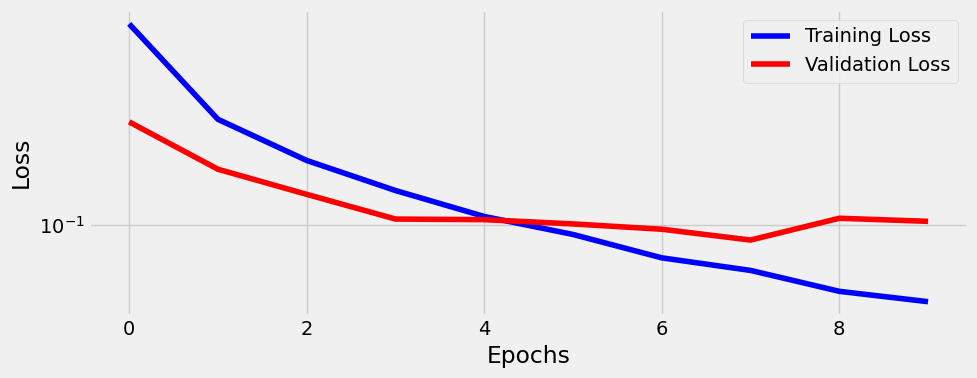

In [40]:
# Plota as curvas de perda
fig_meu_modelo_v2 = arch_v2.plot_losses()
plt.show()

In [ ]:
# 20 epocas
print("\nIniciando o treinamento do 'Seu Modelo v2'...")
arch_v2.train(n_epochs=20) # Vamos treinar por 20 épocas
print("Treinamento concluído!")


Iniciando o treinamento do 'Seu Modelo v2'...


In [ ]:
# Plota as curvas de perda
fig_meu_modelo_v2_20epocas = arch_v2.plot_losses()
plt.show()

In [41]:
# --- Avaliação Final ---
print("\n--- Calculando Métricas Finais para o 'Seu Modelo v2' ---")
all_preds_v2 = []
all_labels_v2 = []

meu_modelo_v2.eval()
with torch.no_grad():
    for images, labels in val_loader_v2:
        images, labels = images.to(arch_v2.device), labels.to(arch_v2.device)
        outputs = meu_modelo_v2(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_v2.extend(predicted.cpu().numpy())
        all_labels_v2.extend(labels.cpu().numpy())

# 1. Acurácia
accuracy_v2 = accuracy_score(all_labels_v2, all_preds_v2)
print(f"Acurácia Final: {accuracy_v2 * 100:.2f}%\n")

# 2. Relatório de Classificação
print("--- Relatório de Classificação (Precisão, Recall, F1-Score) ---")
class_names_v2 = val_dataset_v2.classes
report_v2 = classification_report(all_labels_v2, all_preds_v2, target_names=class_names_v2)
print(report_v2)

# 3. Matriz de Confusão (em texto)
print("\n--- Matriz de Confusão ---")
conf_matrix_v2 = confusion_matrix(all_labels_v2, all_preds_v2)
print("Classes:", class_names_v2)
print(conf_matrix_v2)


--- Calculando Métricas Finais para o 'Seu Modelo v2' ---
Acurácia Final: 97.20%

--- Relatório de Classificação (Precisão, Recall, F1-Score) ---
              precision    recall  f1-score   support

         cat       0.97      0.98      0.98       500
         dog       0.97      0.97      0.97       500
        wild       0.97      0.97      0.97       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500


--- Matriz de Confusão ---
Classes: ['cat', 'dog', 'wild']
[[488   8   4]
 [  5 486   9]
 [  8   8 484]]
